# Beta Globin 

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from matplotlib.patches import Rectangle
import pyBigWig
from deeplift.dinuc_shuffle import dinuc_shuffle

import sys
sys.path.append("../")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

import scipy.stats
from tensorflow import keras

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [5]:
def get_profile(prof, cts):
    return softmax(prof)*(np.exp(cts)-1)

In [6]:
with open("/users/surag/genomes/hg38/hg38.chrom.sizes") as f:
    chromsizes = [x.strip().split('\t') for x in f]
chromsizes = [(x[0], int(x[1])) for x in chromsizes if x]

In [7]:
chromsizes[:2]

[('chr1', 248956422), ('chr2', 242193529)]

## Load Models

In [8]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [9]:
with keras.utils.CustomObjectScope({'tf':tf}):
    ATAC_model = keras.models.load_model("./models/k562.dnase.with.bias.unplugged.0.hdf5",
                                        compile=False)

In [10]:
ATAC_model.input

<tf.Tensor 'sequence:0' shape=(None, 1346, 4) dtype=float32>

In [11]:
ATAC_model.output_shape

[(None, 1000, 1), (None, 1)]

In [12]:
ATAC_cts_explainer = shap.explainers.deep.TFDeepExplainer(
                (ATAC_model.input,
                 tf.reduce_sum(ATAC_model.outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [13]:
ATAC_INP_LEN = ATAC_model.input_shape[1]
ATAC_INP_LEN

1346

In [14]:
ATAC_OUT_LEN = ATAC_model.output_shape[0][1]
ATAC_OUT_LEN

1000

In [15]:
with keras.utils.CustomObjectScope({'tf':tf}):
    chip_model = keras.models.load_model("./models/NFE2.K562.ENCSR000FCC.h5",
                                        compile=False)

In [16]:
chip_model.input_shape

[(None, 2114, 4), (None, 1), (None, 1000, 2)]

In [17]:
chip_model.output_shape

[(None, 1000, 2), (None, 2)]

Change Line 202 in `deep/deep_tf.py` to 

`self._vinputs[op.name] = np.array([t.op in self.between_ops or t.name in [x.name for x in self.model_inputs] for t in op.inputs])`

https://kundajelab.slack.com/archives/C02HU4HHR/p1637459153039900?thread_ts=1637127026.027600&cid=C02HU4HHR

In [18]:
chip_cts_explainer = shap.explainers.deep.TFDeepExplainer(
                ([chip_model.input[0], chip_model.input[1]],
                 tf.reduce_sum(chip_model.outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [19]:
CHIP_INP_LEN = chip_model.input_shape[0][1]
CHIP_INP_LEN

2114

In [20]:
CHIP_OUT_LEN = chip_model.output_shape[0][1]
CHIP_OUT_LEN

1000

## Make bigwigs

rs5764238 C>G

In [21]:
CHR = "chr11"
POS = 5280750

### ATAC

In [22]:
ref_seq = one_hot.dna_to_one_hot([str(hg38[CHR][POS - ATAC_INP_LEN//2:POS + ATAC_INP_LEN//2])])

In [23]:
ref_atac_prof, ref_atac_cts = ATAC_model.predict(ref_seq)

/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [24]:
ref_atac_cts

array([[7.8014727]], dtype=float32)

In [25]:
ref_counts_shap_scores = ATAC_cts_explainer.shap_values(ref_seq)
ref_projected_shap_scores = np.multiply(ref_seq, ref_counts_shap_scores)

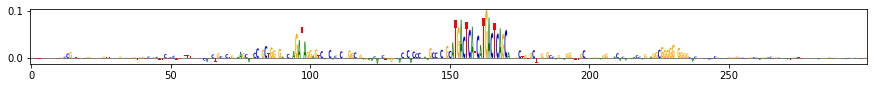

In [26]:
WINDOW = 300
SLICE_START = ATAC_INP_LEN//2 - WINDOW//2
SLICE_END = ATAC_INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(1, figsize=(15,1))

logomaker.Logo(pd.DataFrame(ref_projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax)

plt.show()

In [ ]:
f = pyBigWig.open("./bigwigs/ATAC_imp.bw", "w")
f.addHeader(chromsizes)
f.addEntries([CHR]*ATAC_INP_LEN, 
             list(range(POS-ATAC_INP_LEN//2, POS+ATAC_INP_LEN//2)),
             list(range(POS-ATAC_INP_LEN//2+1, POS+ATAC_INP_LEN//2+1)),
            ref_projected_shap_scores[0].sum(-1))
f.close()

In [ ]:
f = pyBigWig.open("./bigwigs/ATAC_pred.bw", "w")
f.addHeader(chromsizes)
f.addEntries([CHR]*ATAC_OUT_LEN, 
             list(range(POS-ATAC_OUT_LEN//2, POS+ATAC_OUT_LEN//2)),
             list(range(POS-ATAC_OUT_LEN//2+1, POS+ATAC_OUT_LEN//2+1)),
            get_profile(ref_atac_prof, ref_atac_cts)[0])
f.close()

### ChIP

In [23]:
chip_model.input_shape

[(None, 2114, 4), (None, 1), (None, 1000, 2)]

In [24]:
ref_seq_chip = one_hot.dna_to_one_hot([str(hg38[CHR][POS - CHIP_INP_LEN//2:POS + CHIP_INP_LEN//2])])

In [25]:
ref_chip_prof, ref_chip_cts = chip_model.predict([ref_seq_chip, np.zeros((1,1)), np.zeros((1, CHIP_OUT_LEN, 2))])

/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [26]:
ref_chip_cts

array([[1.194863 , 1.2222958]], dtype=float32)

In [27]:
ref_counts_shap_scores = chip_cts_explainer.shap_values([ref_seq_chip, np.zeros((1,1))])
ref_projected_shap_scores = np.multiply(ref_seq_chip, ref_counts_shap_scores[0])

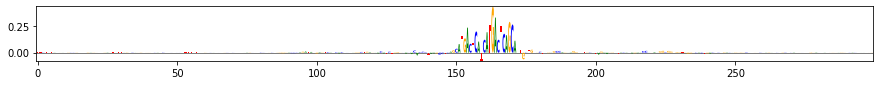

In [28]:
WINDOW = 300
SLICE_START = CHIP_INP_LEN//2 - WINDOW//2
SLICE_END = CHIP_INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(1, figsize=(15,1))

logomaker.Logo(pd.DataFrame(ref_projected_shap_scores[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax)

plt.show()

In [80]:
f = pyBigWig.open("./bigwigs/chip_imp.bw", "w")
f.addHeader(chromsizes)
f.addEntries([CHR]*CHIP_INP_LEN, 
             list(range(POS-CHIP_INP_LEN//2, POS+CHIP_INP_LEN//2)),
             list(range(POS-CHIP_INP_LEN//2+1, POS+CHIP_INP_LEN//2+1)),
            ref_projected_shap_scores[0].sum(-1))
f.close()

In [81]:
f = pyBigWig.open("./bigwigs/chip_pred_plus.bw", "w")
f.addHeader(chromsizes)
f.addEntries([CHR]*CHIP_OUT_LEN, 
             list(range(POS-CHIP_OUT_LEN//2, POS+CHIP_OUT_LEN//2)),
             list(range(POS-CHIP_OUT_LEN//2+1, POS+CHIP_OUT_LEN//2+1)),
            get_profile(ref_chip_prof, ref_chip_cts)[0][:,0])
f.close()

f = pyBigWig.open("./bigwigs/chip_pred_minus.bw", "w")
f.addHeader(chromsizes)
f.addEntries([CHR]*CHIP_OUT_LEN, 
             list(range(POS-CHIP_OUT_LEN//2, POS+CHIP_OUT_LEN//2)),
             list(range(POS-CHIP_OUT_LEN//2+1, POS+CHIP_OUT_LEN//2+1)),
            get_profile(ref_chip_prof, ref_chip_cts)[0][:,1])
f.close()